In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, Dataset, random_split
from torchvision.utils import draw_bounding_boxes

In [ ]:
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import time
import datetime
from tqdm import tqdm



In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.10.0+cpu
0.25.0+cpu


In [ ]:
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transform(train=False):
    if train:
        transforms = A.Compose([
            A.Resize(width=600, height=600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transforms = A.Compose([
            A.Resize(width=600, height=600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transforms



In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.root = root
        self.split = split # train, valid, test
        self.coco = COCO(os.path.join(root, split, '_annotations.coco.json'))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id))>0]

    def load_image(self, id):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self.load_image(id)
        target = self._load_target(id)

        target = copy.deepcopy(self._load_target(id))
        boxes = [t['bbox'] + [t['category_id']] for t in target]
            
        
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']


        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            x_min = box[0]
            y_min = box[1]
            x_max = x_min + box[2]
            y_max = y_min + box[3]
            new_boxes.append([x_min, y_min, x_max, y_max])
        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])    
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    
    def __len__(self):
        return len(self.ids)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sharansmenon/aquarium-dataset")

print("Path to dataset files:", path)

In [ ]:
import shutil
import os

# Where the data is now
source_path = r'C:\Users\lydia\.cache\kagglehub\datasets\sharansmenon\aquarium-dataset\versions\2'

# Where you want it to go (your project folder)
destination_path = r'C:\Users\lydia\coding\image_seg\aquarium_data\Aquarium Combined'

# Move the files
if not os.path.exists(destination_path):
    shutil.copytree(source_path, destination_path)
    print(f"Success! Files moved to {destination_path}")
else:
    print("Folder already exists!")

Folder already exists!


In [ ]:
dataset_path = r'C:/Users/lydia/coding/image_seg/aquarium_data/Aquarium Combined'
coco = COCO(os.path.join(dataset_path, 'train', '_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())  # number of classes
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [ ]:
classes = [categories[i]['name'] for i in categories]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [ ]:
train_dataset = AquariumDetection(root = dataset_path, split='train', transforms=get_transform(train=True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


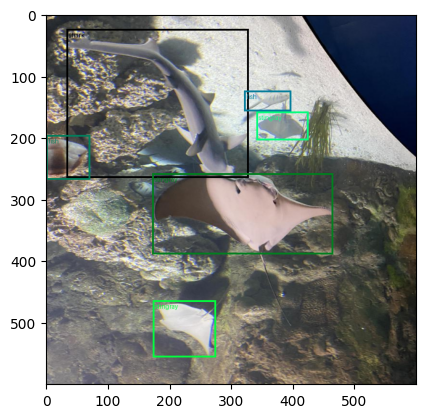

In [ ]:
sample = train_dataset[14]
img_int = torch.tensor(sample[0]*255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=3
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

447

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 
                                                                                           n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\lydia/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:03<00:00, 22.9MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
outputs = model(images, targets)  # Returns losses and detections

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, 
                            momentum=0.9,
                            nesterov=True,
                            weight_decay=1e-4)